In [1]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
from numpy.linalg import matrix_power
from scipy.linalg import expm, expm_frechet
import scipy

In [2]:
def PauliMatrix(i):
    if i == 0:
        return np.array([[1, 0], [0, 1]])
    elif i == 1:
        return np.array([[0, 1], [1, 0]])
    elif i == 2:
        return np.array([[0, -1j], [1j, 0]])
    elif i == 3:
        return np.array([[1, 0], [0, -1]])
    else:
        raise ValueError("i must be 0, 1, 2, or 3.")

def PauliTensor(i, j):
    return np.kron(PauliMatrix(i), PauliMatrix(j))

Geometric model 

$$
    X(x) = \exp( - \tfrac{i}{2} ( \Delta \sigma_Z + \Omega \sigma_X))
$$

$$
    Y(x) = \exp( - \tfrac{i}{2} ( \Delta \sigma_Z + \Omega (\cos \phi \sigma_Y + \sin \phi \sigma_X)) )
$$

$$
    Z = \exp( - \tfrac{i}{2} ( (\tfrac{\pi}{2} + \Delta) \sigma_Z))
$$

In [445]:
def xgate_model(xstate):
    """
    xstate = (Delta, Omega, phi)
    """
    return expm(-(1j/2)*
                (xstate[0]*PauliMatrix(3) + (xstate[1]+np.pi/2)*PauliMatrix(1))
            )

def ygate_model(xstate):
    """
    xstate = (Delta, Omega, phi)
    """
    return expm(-(1j/2)*
                (xstate[0]*PauliMatrix(3) + (xstate[1]+np.pi/2)*(np.sin(xstate[2])*PauliMatrix(1) + np.cos(xstate[2])*PauliMatrix(2)))
            )

def zgate_model(xstate):
    """
    xstate = (Delta, Omega, phi)
    """
    return expm(-(1j/2)*
                ((np.pi/2 + xstate[0])*PauliMatrix(3))
            )

def xgate_grad(xstate):
    generator_at_x = -(1j/2)*(xstate[0]*PauliMatrix(3) + (xstate[1]+np.pi/2)*PauliMatrix(1))
    dx0 = -(1j/2)*PauliMatrix(3)
    dx1 = -(1j/2)*PauliMatrix(1)
    dx2 = np.zeros((2, 2), dtype=complex)
    grad_x0 = expm_frechet(generator_at_x, dx0, compute_expm=False)
    grad_x1 = expm_frechet(generator_at_x, dx1, compute_expm=False)
    grad_x2 = expm_frechet(generator_at_x, dx2, compute_expm=False)
    return np.array([grad_x0, grad_x1, grad_x2])

def ygate_grad(xstate):
    generator_at_x = -(1j/2)*(xstate[0]*PauliMatrix(3) + (xstate[1]+np.pi/2)*(np.sin(xstate[2])*PauliMatrix(1) + np.cos(xstate[2])*PauliMatrix(2)))
    dx0 = -(1j/2)*PauliMatrix(3)
    dx1 = -(1j/2)*(np.sin(xstate[2])*PauliMatrix(1)+ np.cos(xstate[2])*PauliMatrix(2))
    dx2 = -(1j/2)*(xstate[1]+np.pi/2)*(np.cos(xstate[2])*PauliMatrix(1) - np.sin(xstate[2])*PauliMatrix(2))
    grad_x0 = expm_frechet(generator_at_x, dx0, compute_expm=False)
    grad_x1 = expm_frechet(generator_at_x, dx1, compute_expm=False)
    grad_x2 = expm_frechet(generator_at_x, dx2, compute_expm=False)
    return np.array([grad_x0, grad_x1, grad_x2])

def test_xgate_grad(epsilon=1e-8, num_random_samples=10):
    """Check that the gradient of the xgate is correct on 10 random samples."""
    x0_states = np.random.rand(num_random_samples, 3)
    for x0 in x0_states:
        dx0 = np.array([epsilon, 0, 0])
        dx1 = np.array([0, epsilon, 0])
        dx2 = np.array([0, 0, epsilon])
        grad_x0 = (xgate_model(x0 + dx0) - xgate_model(x0 - dx0))/(2*epsilon)
        grad_x1 = (xgate_model(x0 + dx1) - xgate_model(x0 - dx1))/(2*epsilon)
        grad_x2 = (xgate_model(x0 + dx2) - xgate_model(x0 - dx2))/(2*epsilon)

        assert np.allclose(grad_x0, (xgate_grad(x0)[0]))
        assert np.allclose(grad_x1, (xgate_grad(x0)[1]))
        assert np.allclose(grad_x2, (xgate_grad(x0)[2]))

def test_ygate_grad(epsilon=1e-8, num_random_samples=10):
    """Check that the gradient of the ygate is correct on 10 random samples."""
    x0_states = np.random.rand(num_random_samples, 3)
    for x0 in x0_states:
        dx0 = np.array([epsilon, 0, 0])
        dx1 = np.array([0, epsilon, 0])
        dx2 = np.array([0, 0, epsilon])
        grad_x0 = (ygate_model(x0 + dx0) - ygate_model(x0 - dx0))/(2*epsilon)
        grad_x1 = (ygate_model(x0 + dx1) - ygate_model(x0 - dx1))/(2*epsilon)
        grad_x2 = (ygate_model(x0 + dx2) - ygate_model(x0 - dx2))/(2*epsilon)

        assert np.allclose(grad_x0, (ygate_grad(x0)[0]))
        assert np.allclose(grad_x1, (ygate_grad(x0)[1]))
        assert np.allclose(grad_x2, (ygate_grad(x0)[2]))

In [446]:
test_xgate_grad()
test_ygate_grad()

AssertionError: 

# circuit definition
circuit = (germ, prep_sequence, meas_sequence)

In [463]:
all_state_preps = ['', 'Y', 'YY', 'YYY', 'X', 'XXX']
all_measurements = ['', 'Y', 'YY', 'YYY', 'X', 'XXX']
germ_list = ['X', 'Y', 'XX', 'YY', 'XY', 'XXY', 'XYX', 'Z', 'ZZ', 'ZYZ', 'YZY', 'XZX', 'ZXXXXZZXXXXZ']

In [464]:
def multiply_sequence(sequence, Xdef, Ydef, Zdef):
    """Multiply a sequence of X and Y gates together."""
    circ = np.eye(2)
    for c in sequence:
        if c == 'X':
            circ = Xdef@circ
        elif c == 'Y':
            circ = Ydef@circ
        elif c == 'Z':
            circ = Zdef@circ
        else:
            raise ValueError("sequence must only contain 'X', 'Y' and 'Z' characters.")
    return circ

def probability(xstate, d, circ_def):
    # assume a convention where the gates go from left to right in the string
    Xgate = xgate_model(xstate)
    Ygate = ygate_model(xstate)
    Zgate = zgate_model(xstate)
    germ, prep, meas = circ_def
    prep_unitary = multiply_sequence(prep, Xgate, Ygate, Zgate)
    germ_unitary = multiply_sequence(germ, Xgate, Ygate, Zgate)
    meas_unitary = multiply_sequence(meas, Xgate, Ygate, Zgate)
    circ_unitary = meas_unitary@np.linalg.matrix_power(germ_unitary, d)@prep_unitary
    prob = abs(circ_unitary[0, 0])**2
    return prob

# def unitary_grad_of_sequence(xstate, sequence, Xdef, Ydef, xgrad_def, ygrad_def):
#     tot_unitary_grads = np.zeros((len(xstate), 2, 2), dtype=complex)
#     for idx, c in enumerate(sequence):
#         pre_subcirc = sequence[:idx]
#         post_subcirc = sequence[idx+1:]
#         pre_subcirc_unitary = multiply_sequence(pre_subcirc, Xdef, Ydef)
#         post_subcirc_unitary = multiply_sequence(post_subcirc, Xdef, Ydef)
#         if c == 'X':  
#             for k in range(len(xstate)):
#                 tot_unitary_grads[k] += post_subcirc_unitary@xgrad_def[k]@pre_subcirc_unitary
#         elif c == 'Y':
#             for k in range(len(xstate)):
#                 tot_unitary_grads[k] += post_subcirc_unitary@ygrad_def[k]@pre_subcirc_unitary
#         else:
#             raise ValueError("sequence must only contain 'X' and 'Y' characters.")
#     return tot_unitary_grads

# def probability_grad_of_sequence(xstate, sequence, Xdef, Ydef, xgrad_def, ygrad_def):
#     U_grad = unitary_grad_of_sequence(xstate, sequence, Xdef, Ydef, xgrad_def, ygrad_def)
#     U_tot = multiply_sequence(sequence, Xdef, Ydef)
#     pgrad = np.conj(U_tot[0, 0])*U_grad[:, 0, 0] + U_tot[0, 0]*np.conj(U_grad[:, 0, 0])
#     assert np.allclose(pgrad.imag, 0), f"Imaginary part of probability gradient is not zero: {pgrad.imag}."
#     return pgrad.real

# def unitary_grad_of_germ(xstate, d, germ, Xdef, Ydef, xgrad_def, ygrad_def):
#     U_germ = multiply_sequence(germ, Xdef, Ydef)
#     total_unitary_grad = np.zeros((3, 2, 2), dtype=complex)
#     germ_grad = unitary_grad_of_sequence(xstate, germ, Xdef, Ydef, xgrad_def, ygrad_def)
#     for i in range(d):
#         for k in range(len(xstate)):
#             total_unitary_grad[k] += np.linalg.matrix_power(U_germ, i)@ germ_grad[k]@np.linalg.matrix_power(U_germ, d-i-1)
#     return total_unitary_grad

# def probability_grad_of_germ(xstate, d, germ, Xdef, Ydef, xgrad_def, ygrad_def):
#     U_grad = unitary_grad_of_germ(xstate, d, germ, Xdef, Ydef, xgrad_def, ygrad_def)
#     U_tot = multiply_sequence(germ*d, Xdef, Ydef)
#     pgrad = np.conj(U_tot[0, 0])*U_grad[:, 0, 0] + U_tot[0, 0]*np.conj(U_grad[:, 0, 0])
#     assert np.allclose(pgrad.imag, 0), f"Imaginary part of probability gradient is not zero: {pgrad.imag}."
#     return pgrad.real


def probability_grad(xstate, d, circ_def, epsilon=1e-8):
    # finite difference gradient
    grad = np.zeros(3)
    for i in range(3):
        dx = np.zeros(3)
        dx[i] = epsilon
        prob_dx = probability(xstate + dx, d, circ_def)
        prob_dxm = probability(xstate - dx, d, circ_def)
        grad[i] = (prob_dx - prob_dxm)/(2*epsilon)
    return grad


    # assume a convention where the gates go from left to right in the string
    # Xgate = xgate_model(xstate)
    # Ygate = ygate_model(xstate)
    # Xgrad = xgate_grad(xstate)
    # Ygrad = ygate_grad(xstate)
    # germ, prep, meas = circ_def

    # # state prep and meas U grad and unitaries
    # prep_grad = unitary_grad_of_sequence(xstate, prep, Xgate, Ygate, Xgrad, Ygrad)
    # meas_grad = unitary_grad_of_sequence(xstate, meas, Xgate, Ygate, Xgrad, Ygrad)
    # U_prep = multiply_sequence(prep, Xgate, Ygate)
    # U_meas = multiply_sequence(meas, Xgate, Ygate)


    # # germ U grad and unitary 
    # germ_grad = unitary_grad_of_germ(xstate, d, germ, Xgate, Ygate, Xgrad, Ygrad)
    # U_germ = multiply_sequence(germ, Xgate, Ygate)

    # # total U grad and unitary
    # U_tot = U_meas@U_germ@U_prep
    # tot_grad = (
    #     U_meas@U_germ@prep_grad +
    #     U_meas@germ_grad@U_prep +
    #     meas_grad@U_germ@U_prep
    # )

    # pgrad = np.conj(U_tot[0, 0])*tot_grad[:, 0, 0] + U_tot[0, 0]*np.conj(tot_grad[:, 0, 0])
    

    # G = germ*d
    # circ = prep + G + meas
    # prob_unitary_grads = np.zeros((3, 2, 2), dtype=complex)
    # U_tot = multiply_sequence(circ, Xgate, Ygate)
    # for idx, c in enumerate(circ):
    #     pre_subcirc = circ[:idx]
    #     post_subcirc = circ[idx+1:]
    #     pre_subcirc_unitary = multiply_sequence(pre_subcirc, Xgate, Ygate)
    #     post_subcirc_unitary = multiply_sequence(post_subcirc, Xgate, Ygate)
    #     if c == 'X':  
    #         for k in range(3):
    #             prob_unitary_grads[k] += post_subcirc_unitary@Xgrad[k]@pre_subcirc_unitary
    #     elif c == 'Y':
    #         for k in range(3):
    #             prob_unitary_grads[k] += post_subcirc_unitary@Ygrad[k]@pre_subcirc_unitary
    #     else:
    #         raise ValueError("circuit string must only contain 'X' and 'Y' characters.")
    # U_tot = multiply_sequence(circ, Xgate, Ygate)
    # pgrad = np.conj(U_tot[0, 0])*prob_unitary_grads[:, 0, 0] + U_tot[0, 0]*np.conj(prob_unitary_grads[:, 0, 0])
    assert np.allclose(pgrad.imag, 0), f"Imaginary part of probability gradient is not zero: {pgrad.imag}."
    return pgrad.real

def make_random_circ_def(length, prep_length=3, meas_length=3):
    germ_part = ''.join(np.random.choice(germ_list, length))
    prep_part = ''.join(np.random.choice(all_state_preps, prep_length))
    meas_part = ''.join(np.random.choice(all_measurements, meas_length))
    return (germ_part, prep_part, meas_part)

def probability_grad_check(num_xstates=10, num_circuits=10, epsilon=1e-8, delta=1e-5):
    """Check that the gradient of the probability function is correct."""
    xstates = np.random.rand(num_xstates, 3)
    for xstate in xstates:
        for _ in range(num_circuits):
            d = np.random.randint(1, 2)
            circ_def = make_random_circ_def(np.random.randint(1, 10))
            grad = probability_grad(xstate, d, circ_def)
            dx0 = np.array([epsilon, 0, 0])
            dx1 = np.array([0, epsilon, 0])
            dx2 = np.array([0, 0, epsilon])
            prob_dx0m = probability(xstate - dx0, d, circ_def)
            prob_dx1m = probability(xstate - dx1, d, circ_def)
            prob_dx2m = probability(xstate - dx2, d, circ_def)
            prob_dx0 = probability(xstate + dx0, d, circ_def)
            prob_dx1 = probability(xstate + dx1, d, circ_def)
            prob_dx2 = probability(xstate + dx2, d, circ_def)
            grad_dx0 = (prob_dx0 - prob_dx0m)/(2*epsilon)
            grad_dx1 = (prob_dx1 - prob_dx1m)/(2*epsilon)
            grad_dx2 = (prob_dx2 - prob_dx2m)/(2*epsilon)
            assert np.allclose(grad, np.array([grad_dx0, grad_dx1, grad_dx2]), atol=delta), f"Analytic grad {grad} does not match numerical grad {np.array([grad_dx0, grad_dx1, grad_dx2])} for xstate {xstate}, d {d}, and circ_def {circ_def}."
probability_grad_check()

Experiment design and fisher information

Edesign is a dictionary { d : (germ, prep, meas) }

Fisher information of an edesign is the fisher information of the circuits 

$$
    [I(\theta| \mathcal{E})]_{i,j} = \sum_{n} \frac{1}{P(n|\theta, \mathcal{E})} \left( \frac{\partial }{\partial \theta_i}P(n|\theta, \mathcal{E})  \right) \left( \frac{\partial }{\partial \theta_j}P(n|\theta, \mathcal{E})  \right) 
$$

I'll use the fisher information score

$$
    S(I) = \log |I'| = \sum_j \log \lambda'_j(I)
$$
after clipping the eigenvalues to the range $[\epsilon, \infty]$ for small $\epsilon$. To score new circuits, I'll use
$$
    S(I_\text{prior tot} + I_\text{new}) - S(I_\text{prior tot})
$$

In [465]:
def edesign_probability(xstate, edesign):
    probs = dict()
    for idx, d in enumerate(edesign.keys()):
        probs[d] = []
        for circ_def in edesign[d]:
            probs[d].append( probability(xstate, d, circ_def) )
    return probs

def edesign_gradients(xstate, edesign):
    prob_grads = dict()
    for idx, d in enumerate(edesign.keys()):
        prob_grads[d] = []
        for circ_def in edesign[d]:
            prob_grads[d].append( probability_grad(xstate, d, circ_def) )
    return prob_grads

def edesign_observation(xstate, edesign, num_shots=1000):
    probs = edesign_probability(xstate, edesign)
    emperical_dists = dict()
    for d in edesign.keys():
        emperical_dists[d] = []
        for prob in probs[d]:
            emperical_dists[d].append(np.random.binomial(num_shots, prob))
    return emperical_dists

In [466]:
def fisher_information_matrix(xstate, edesign):
    ed_probs = edesign_probability(xstate, edesign)
    ed_grads = edesign_gradients(xstate, edesign)
    probs = [value for sublist in ed_probs.values() for value in sublist]
    grads = [value for sublist in ed_grads.values() for value in sublist]
    fisher_info = np.zeros((len(xstate), len(xstate)))
    for idx, p in enumerate(probs):
        if p == 0:
            fisher_info += np.zeros((len(xstate), len(xstate)))
        else:
            fisher_info += np.outer(grads[idx], grads[idx])/p
    return fisher_info

def score_fisher_information_matrix(fmat, clip=1e-19):
    evals = np.linalg.eigvals(fmat)
    # clip 
    evals = np.clip(evals, clip, float('inf'))
    if np.any(evals <= 0):
        print(evals, np.clip(evals, clip, np.max(evals)))
    return np.sum(np.log(evals))

In [467]:
def find_minimial_circuits_fixed_depth(xestimate, d, num_circs, germ_list, prep_list, meas_list):
    """Find the minimal circuits for a fixed depth."""
    all_circuits = dict()
    for germ in germ_list:
        for prep in prep_list:
            for meas in meas_list:
                all_circuits[(germ, prep, meas)] = prep + germ*d + meas
    
    minimal_circuits = []
    total_fisher_info = np.zeros((len(xestimate), len(xestimate)))
    for r in range(num_circs):
        scores = {}
        for circ_def, circ in all_circuits.items():
            if circ_def in minimal_circuits:
                continue
            I_circ = fisher_information_matrix(xestimate, {d: [circ_def]})
            new_fisher = total_fisher_info + I_circ
            score = score_fisher_information_matrix(new_fisher) 
            scores[circ_def] = score
        best_circ_def = max(scores, key=scores.get)
        minimal_circuits.append(best_circ_def)
        total_fisher_info += fisher_information_matrix(xestimate, {d: [best_circ_def]})
    if np.linalg.matrix_rank(total_fisher_info) < len(xestimate):
        Warning( np.linalg.matrix_rank(total_fisher_info) )
    return minimal_circuits

In [468]:


reduced_germ_list = ['X', 'Y', 'XY']
reduced_state_preps = ['', 'X']
reduced_measurements = ['YYY', 'XXX']

In [469]:
def make_complete_experiment_design(depths):
    edesign = {}
    for d in depths:
        edesign[d] = []
        for prep in all_state_preps:
            for germ in germ_list:
                for meas in all_measurements:
                    edesign[d].append((germ*d, prep, meas))
    return edesign

def make_minimal_experiment_design(xestimate, depths, num_circs, germ_list, prep_list, meas_list):
    edesign = {}
    for d in depths:
        edesign[d] = find_minimial_circuits_fixed_depth(xestimate, d, num_circs, germ_list, prep_list, meas_list)
    return edesign

def make_reduced_edeisgn(depths):
    reduced_edesign = {}
    for d in depths:
        reduced_edesign[d] = []
        for prep in all_state_preps:
            for germ in reduced_germ_list:
                for meas in all_measurements:
                    reduced_edesign[d].append((germ*d, prep, meas))
    return reduced_edesign

In [470]:
custom_circuit_list = [
    ('X', '', ''), 
    ('X', '', 'X'), 
    ('Y', '', ''), 
    ('Y', '', 'Y'), 
    ('XX', 'X', ''),
    ('XX', 'X', 'X'),
    ('XYX', '', ''),
    ('XYX', '', 'X')
]

def make_custom_experiment_design(depths):
    edesign = {}
    for d in depths:
        edesign[d] = custom_circuit_list
    return edesign

In [492]:
minimial_edesign = make_minimal_experiment_design(np.array([0, 0, 0]), [16], 6, germ_list, all_state_preps, all_measurements)

In [493]:
edesign = make_complete_experiment_design([16])

In [494]:
minimial_edesign

{16: [('XY', 'X', 'X'),
  ('ZXXXXZZXXXXZ', 'X', 'X'),
  ('XX', 'XXX', 'XXX'),
  ('XXY', 'X', 'X'),
  ('YY', 'YYY', 'YYY'),
  ('ZXXXXZZXXXXZ', 'XXX', 'XXX')]}

In [495]:
target_state = np.array([0, 0, 0])
covar = 0.01
true_state = target_state + np.random.normal(0, covar, 3)

In [496]:
minimal_fisher_info = fisher_information_matrix(true_state, minimial_edesign)

In [500]:
fisher_info = fisher_information_matrix(true_state, make_complete_experiment_design([16]))

In [501]:
np.linalg.eigvals(fisher_info)

array([13703503.19069776,  9115421.59249534,  1517517.71304014])

In [502]:
np.linalg.eigvals(minimal_fisher_info)

array([5567.70643195, 3217.44063781,  439.3791527 ])

## make a Kalman filter

In [503]:
from filterpy.kalman import UnscentedKalmanFilter, MerweScaledSigmaPoints

In [504]:
from filterpy.kalman import unscented_transform
from numpy import eye, zeros, dot, isscalar, outer
from copy import deepcopy

In [505]:
class KalmanFilter:
    def __init__(self, xinitial, Pinitial, Q=None, record_history=True) -> None:
        self.x = xinitial
        self.P = Pinitial
        if Q is None:
            self.Q = np.zeros((len(xinitial), len(xinitial)))
        else:
            self.Q = Q
        if record_history:
            self.history = {'x': [self.x], 'P': [self.P]}

    def predict(self):
        # TODO : implmenet controls
        self.x = self.x
        self.P = self.P + self.Q

    def update(self, observation, edesign, r):
        jacobian_list = []
        prediction_list = []
        for d in edesign.keys():
            for circ_def in edesign[d]:
                jacobian = probability_grad(self.x, d, circ_def)
                prediction = probability(self.x, d, circ_def)
                jacobian_list.append(jacobian)
                prediction_list.append(prediction)
        total_jac = np.vstack(jacobian_list)
        total_pred = np.vstack(prediction_list).flatten()
        S = total_jac@self.P@total_jac.T + np.diag(r*np.ones(len(total_pred)))
        K = self.P@total_jac.T@np.linalg.inv(S)
        self.x = self.x + K@(observation - total_pred)
        self.P = self.P - K@total_jac@self.P
        if hasattr(self, 'history'):
            self.history['x'].append(self.x)
            self.history['P'].append(self.P)

    def iterated_update(self, observation, edesign, r, max_iter=10, tol=1e-4, return_iterations=False):
        if return_iterations:
            iterations = [self.x]
        R = np.diag(r*np.ones(len(observation))) 
        for i in range(max_iter):
            jac_list = []
            pred_list = []
            for d in edesign.keys():
                for circ_def in edesign[d]:
                    jac = probability_grad(self.x, d, circ_def)
                    pred = probability(self.x, d, circ_def)
                    jac_list.append(jac)
                    pred_list.append(pred)
            total_jac = np.vstack(jac_list)
            if tol == "R-dependent":
                tol = np.sqrt(np.trace(total_jac.T @ R @ total_jac))
            total_pred = np.vstack(pred_list).flatten()
            S = total_jac@self.P@total_jac.T + R
            K = self.P@total_jac.T@np.linalg.inv(S)
            new_x = self.x + K@(observation - total_pred)
            if return_iterations:
                iterations.append(new_x)
            update_mag = np.linalg.norm(new_x - self.x)
            self.x = new_x
            if update_mag < tol:
                break
        self.P = self.P - K@total_jac@self.P
        if hasattr(self, 'history'):
            self.history['x'].append(self.x)
            self.history['P'].append(self.P)
        if i == max_iter - 1:
            print(f"WARNING: Max iterations reached without convergence with tolerance {tol}.")
        if return_iterations:
            return np.array(iterations)
        
    def plot_rms_history(self, xtrue, ax=None):
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        rms_history = np.zeros(len(self.history['x']))
        expected_errors = np.zeros(len(self.history['x']))
        for idx, x in enumerate(self.history['x']):
            rms_history[idx] = np.linalg.norm(x - xtrue)
            expected_errors[idx] = np.sqrt(np.trace(self.history['P'][idx]))
        ax.plot(rms_history)
        # add error bars based on expected errors
        ax.errorbar(np.arange(len(rms_history)), rms_history, yerr=expected_errors, fmt='none', ecolor='r')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('RMS Error')

    def plot_residual_history(self, xtrue, axs=None):
        # plot the theta, phi, chi resuduals against xtrue
        if axs is None:
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        residuals = np.zeros((len(self.history['x']), 3))
        for idx, x in enumerate(self.history['x']):
            residuals[idx] = x - xtrue
        axs[0].plot(residuals[:, 0])
        axs[0].set_xlabel('Update index')
        axs[0].set_ylabel('Theta Residual')
        axs[1].plot(residuals[:, 1])
        axs[1].set_xlabel('Update index')
        axs[1].set_ylabel('Phi Residual')
        axs[2].plot(residuals[:, 2])
        axs[2].set_xlabel('Update index')
        axs[2].set_ylabel('Chi Residual')
        

In [506]:
def fx(x, dt, u=None):
    if u is None:
        u = np.zeros(len(x))
    return x + u

def hx(x, edesign):
    return edesign_probability(x, edesign)
def vector_from_dict(d):
    # join the arrays in the dictionary into a single array
    return np.array([value for sublist in d.values() for value in sublist])

class MyUKF(UnscentedKalmanFilter):
    def __init__(self, num_params, edesign, num_shots):
        self.edesign = edesign
        self.dt=1

        # calculate number of circuits
        num_circs = 0
        for d in edesign.keys():
            num_circs += len(edesign[d])
        self.num_circs = num_circs
        self.R = (0.25/num_shots)*np.eye(num_circs)

        self.points = MerweScaledSigmaPoints(num_params, alpha=1e-3, beta=2, kappa=0)
        super().__init__(num_params, num_circs, dt=1, hx=self.hx, fx=self.fx, points=self.points)

    def fx(self, x, dt, u=None):
        if u is None:
            u = np.zeros(len(x))
        return x + u

    def hx(self, x, d):
        return np.array(edesign_probability(x, {d: self.edesign[d]})[d]).flatten()

    def check_consistency_at_d(self, d):
        """Check that the experiment design at depth d is consistent for the sigma points."""
        pass


        
    def update(self, observations, num_shots, UT=None, hx=None, max_iter=10, tol=1e-3, **hx_args):
        """
        Update the UKF with the given measurements. On return,
        self.x and self.P contain the new mean and covariance of the filter.

        update one generation at a time

        Parameters
        ----------

        z : numpy.array of shape (dim_z)
            measurement vector

        R : numpy.array((dim_z, dim_z)), optional
            Measurement noise. If provided, overrides self.R for
            this function call.

        UT : function(sigmas, Wm, Wc, noise_cov), optional
            Optional function to compute the unscented transform for the sigma
            points passed through hx. Typically the default function will
            work - you can use x_mean_fn and z_mean_fn to alter the behavior
            of the unscented transform.

        hx : callable h(x, **hx_args), optional
            Measurement function. If not provided, the default
            function passed in during construction will be used.

        **hx_args : keyword argument
            arguments to be passed into h(x) after x -> h(x, **hx_args)
        """


        if hx is None:
            hx = self.hx

        if UT is None:
            UT = unscented_transform

        # elif isscalar(R):
        #     R = eye(self._dim_z) * R

        for d in self.edesign.keys():
            counts = np.array(observations[d])
            z = counts/num_shots
            alpha_vec = (counts + np.ones(len(counts)))/(num_shots + len(counts))
            #R = np.diag(alpha_vec*(1-alpha_vec)/(num_shots + len(counts) +1))
            R = (0.25/num_shots)*np.eye(len(counts))

            for i in range(max_iter):
                # pass prior sigmas through h(x) to get measurement sigmas
                # the shape of sigmas_h will vary if the shape of z varies, so
                # recreate each time
                sigmas_h = []
                for s in self.sigmas_f:
                    sigmas_h.append(hx(s, d))

                self.sigmas_h = np.atleast_2d(sigmas_h)

                # mean and covariance of prediction passed through unscented transform
                zp, self.S = UT(self.sigmas_h, self.Wm, self.Wc, R, self.z_mean, self.residual_z)
                self.SI = self.inv(self.S)

                # compute cross variance of the state and the measurements
                Pxz = self.cross_variance(self.x, zp, self.sigmas_f, self.sigmas_h)
                # print(self.sigmas_f, self.sigmas_h)

                # print(np.linalg.norm(Pxz), np.linalg.norm(self.S), np.linalg.norm(self.SI))

                self.K = dot(Pxz, self.SI)        # Kalman gain
                self.y = self.residual_z(z, zp)   # residual


                x_new = self.x + dot(self.K, self.y)
                # phase unwrapping on x[2]
                x_new[2] = np.unwrap([x_new[2]])
                if np.linalg.norm(x_new - self.x) < tol:
                    break
                else:
                    self.x = x_new
                    self.compute_process_sigmas(self.dt, self.fx)
                    #if i == max_iter - 1:
                    #    print(f"WARNING: Max iterations reached without convergence with tolerance {tol}.")
            self.x = x_new
            self.P = self.P - self.K@self.S@self.K.T

            # save measurement and posterior state
            self.x_post = self.x.copy()
            self.z = deepcopy(z)
            self.P_post = self.P.copy()

        # set to None to force recompute
        self._log_likelihood = None
        self._likelihood = None
        self._mahalanobis = None


    # def control_update(self, observations, num_shots, UT=None, hx=None, max_iter=10, tol=1e-3, **hx_args):
    #     """
    #     Update the UKF with the given measurements. On return,
    #     self.x and self.P contain the new mean and covariance of the filter.

    #     update one generation at a time

    #     Parameters
    #     ----------

    #     z : numpy.array of shape (dim_z)
    #         measurement vector

    #     R : numpy.array((dim_z, dim_z)), optional
    #         Measurement noise. If provided, overrides self.R for
    #         this function call.

    #     UT : function(sigmas, Wm, Wc, noise_cov), optional
    #         Optional function to compute the unscented transform for the sigma
    #         points passed through hx. Typically the default function will
    #         work - you can use x_mean_fn and z_mean_fn to alter the behavior
    #         of the unscented transform.

    #     hx : callable h(x, **hx_args), optional
    #         Measurement function. If not provided, the default
    #         function passed in during construction will be used.

    #     **hx_args : keyword argument
    #         arguments to be passed into h(x) after x -> h(x, **hx_args)
    #     """


    #     if hx is None:
    #         hx = self.hx

    #     if UT is None:
    #         UT = unscented_transform

    #     # elif isscalar(R):
    #     #     R = eye(self._dim_z) * R

    #     for d in self.edesign.keys():
    #         counts = np.array(observations[d])
    #         z = counts/num_shots
    #         alpha_vec = (counts + np.ones(len(counts)))/(num_shots + len(counts))
    #         #R = np.diag(alpha_vec*(1-alpha_vec)/(num_shots + len(counts) +1))
    #         R = (0.25/num_shots)*np.eye(len(counts))

    #         for i in range(max_iter):
    #             # pass prior sigmas through h(x) to get measurement sigmas
    #             # the shape of sigmas_h will vary if the shape of z varies, so
    #             # recreate each time
    #             sigmas_h = []
    #             for s in self.sigmas_f:
    #                 sigmas_h.append(hx(s, d))

    #             self.sigmas_h = np.atleast_2d(sigmas_h)

    #             # mean and covariance of prediction passed through unscented transform
    #             zp, self.S = UT(self.sigmas_h, self.Wm, self.Wc, R, self.z_mean, self.residual_z)
    #             self.SI = self.inv(self.S)

    #             # compute cross variance of the state and the measurements
    #             Pxz = self.cross_variance(self.x, zp, self.sigmas_f, self.sigmas_h)
    #             # print(self.sigmas_f, self.sigmas_h)

    #             # print(np.linalg.norm(Pxz), np.linalg.norm(self.S), np.linalg.norm(self.SI))

    #             self.K = dot(Pxz, self.SI)        # Kalman gain
    #             self.y = self.residual_z(z, zp)   # residual


    #             u = -dot(self.K, self.y)
    #             x_new = self.x + dot(self.K, self.y)
    #             # phase unwrapping on x[2]
    #             if np.linalg.norm(x_new - self.x) < tol:
    #                 break
    #             else:
    #                 self.x = x_new
    #                 self.update()
    #                 #if i == max_iter - 1:
    #                 #    print(f"WARNING: Max iterations reached without convergence with tolerance {tol}.")
    #         self.x = x_new
    #         self.P = self.P - self.K@self.S@self.K.T

    #         # save measurement and posterior state
    #         self.x_post = self.x.copy()
    #         self.z = deepcopy(z)
    #         self.P_post = self.P.copy()

        
    #     # set to None to force recompute
    #     self._log_likelihood = None
    #     self._likelihood = None
    #     self._mahalanobis = None
    #     u = - self.x 
    #     self.x = np.zeros(len(self.x))
    #     return u


In [507]:
edesign = make_complete_experiment_design([1, 2, 4, 8])

In [508]:
true_state = np.array([0, 0, 0])
covar = 0.1
x0 = true_state + np.random.normal(0, covar, 3)
P0 = np.eye(3)*covar
num_shots = 1000

In [509]:
#ekf = KalmanFilter(x0, P0, record_history=True)

In [510]:
ukf = MyUKF(3, edesign, num_shots)
ukf.x = x0
ukf.P = P0
ukf.R = (0.25/num_shots)*np.eye(ukf.num_circs)

In [511]:
observations = edesign_observation(true_state, edesign, num_shots)

In [512]:
ukf.predict()
ukf.update(observations, num_shots, tol=1e-4)


In [513]:
#ekf.iterated_update(observations, edesign, 0.25/num_shots)

In [514]:
# original error
np.linalg.norm(x0 - true_state)

0.14454145299373858

In [515]:
# ekf error
#np.linalg.norm(ekf.x - true_state)

In [516]:
# ukf error
np.linalg.norm(ukf.x - true_state)

6.656803871126872e-05

## tomographic estimation under drift

In [761]:
custom_circuit_list = [
    ('X', '', ''), 
    ('X', '', 'X'), 
    ('XYX', '', ''),
    ('XYX', '', 'X'), 
    ('ZXXXXZZXXXXZ', 'Y', 'YYY'),
    ('ZXXXXZZXXXXZ', 'Y', 'XXX'),
]

def make_custom_experiment_design(depths):
    edesign = {}
    for d in depths:
        edesign[d] = custom_circuit_list
    return edesign

In [762]:
depths = [8, 16, 32, 64, 128, 256]
edesign = make_custom_experiment_design(depths)

In [763]:
Q = np.eye(3)*0.0005
target_state = np.array([0, 0, 0])


In [764]:
0.5*np.pi/np.sqrt(5*np.trace(Q))

18.137993642342177

In [765]:
num_steps = 100
num_iterations = 10
tol = 1e-4

In [766]:
from tqdm import tqdm

In [767]:
#ekf = KalmanFilter(x0, P0, Q=Q, record_history=True)
num_shots = 100

covar = 0.001
x0 = target_state 
P0 = np.eye(3)*covar

true_state = target_state + np.random.normal(0, covar, 3)


ukf = MyUKF(3, edesign, num_shots)
ukf.x = x0
ukf.P = P0
ukf.Q = Q


ukf_history = [x0]
covar_history = [P0]
true_state_history = [true_state]
for i in tqdm(range(num_steps)):
    true_state = true_state + np.random.multivariate_normal(np.zeros(3), Q)
    true_state_history.append(true_state)
    observations = edesign_observation(true_state, edesign, num_shots)
    ukf.predict(u=np.zeros(3))
    ukf.update(observations, num_shots, max_iter=5,tol=1e-5)
    ukf_history.append(ukf.x)
    covar_history.append(ukf.P)
    # ekf.predict()
    # ekf.iterated_update(observations, edesign, 0.25/num_shots)
    #ekf_history.append(ekf.x)

100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


In [727]:
ukf_history = np.array(ukf_history)
covar_history = np.array(covar_history)
#ekf_history = np.array(ekf_history)
true_state_history = np.array(true_state_history)

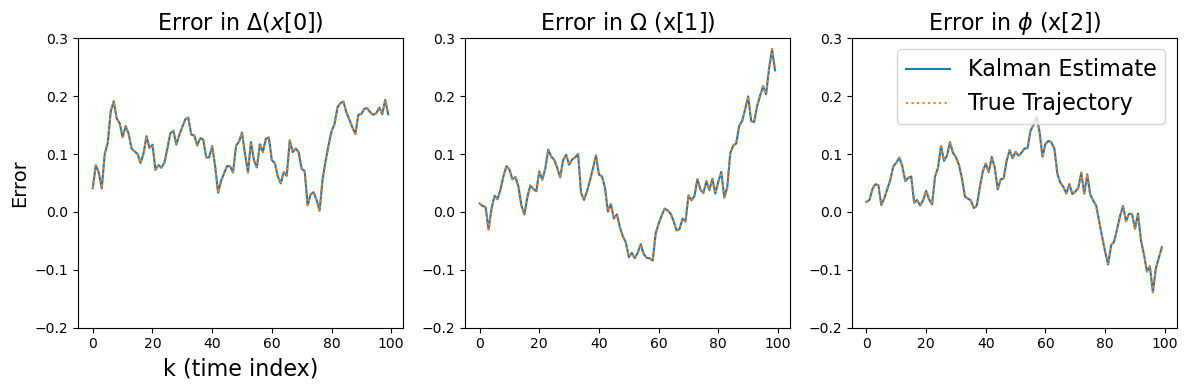

In [731]:
# plot the estimated and true state over time
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].plot(ukf_history[:, 0], label='Kalman Estimate')
# plot the error bars as colored regions
# y errors are the diagonal of the square root of the covariance matrix
yerr = np.sqrt(covar_history[:, 0, 0])
ax[0].fill_between(np.arange(num_steps), ukf_history[:, 0] - yerr, ukf_history[:, 0] + yerr, alpha=0.3)
ax[0].plot(true_state_history[:, 0], label='True Trajectory', linestyle='dotted')
#ax[0].plot(ekf_history[:, 0], label='EKF')

ax[1].plot(ukf_history[:, 1], label='Kalman Estimate')
yerr = np.sqrt(covar_history[:, 1, 1])
ax[1].fill_between(np.arange(num_steps), ukf_history[:, 1] - yerr, ukf_history[:, 1] + yerr, alpha=0.3)
ax[1].plot(true_state_history[:, 1], label='True Trajectory', linestyle='dotted')

ax[2].plot(ukf_history[:, 2], label='Kalman Estimate')
yerr = np.sqrt(covar_history[:, 2, 2])
ax[2].fill_between(np.arange(num_steps), ukf_history[:, 2] - yerr, ukf_history[:, 2] + yerr, alpha=0.3)
ax[2].plot(true_state_history[:, 2], label='True Trajectory', linestyle='dotted')

# ax[1].plot(true_state_history[:, 1], label='True Trajectory', linewidth=5)
# ax[1].plot(ukf_history[:, 1], label='Kalman Estimate')

# ax[2].plot(true_state_history[:, 2], label='True Trajectory', linewidth=5)
# ax[2].plot(ukf_history[:, 2], label='Kalman Estimate')


font_size = 16
ax[0].set_xlabel('k (time index)', fontsize=font_size)
ax[0].set_title('Error in $\\Delta (x[0])$', fontsize=font_size)
ax[0].set_ylabel('Error', fontsize=14)

#ax[1].plot(ekf_history[:, 1], label='EKF')
ax[1].set_title('Error in $\\Omega$ (x[1])', fontsize=font_size)

ax[2].set_title('Error in $\\phi$ (x[2])', fontsize=font_size)
# make the font larger for the labels

# set the axes to the same range 
yrange = [-0.2, 0.3]
for a in ax:
    a.set_ylim(yrange)



ax[2].legend(fontsize=font_size)
# set tight layout
plt.tight_layout()


In [732]:
# calculate the total uncertainty in the state as a function of time
total_uncertainty = np.zeros(num_steps)
for i in range(num_steps):
    total_uncertainty[i] = np.sqrt(np.trace(covar_history[i]))/3

In [733]:
total_uncertainty

array([0.00019081, 0.00019759, 0.00019584, 0.00020283, 0.00019012,
       0.00018261, 0.00018567, 0.00020565, 0.00017467, 0.00020007,
       0.00018048, 0.00019596, 0.0001797 , 0.00019169, 0.00019713,
       0.00018672, 0.00018327, 0.00018262, 0.00018577, 0.00018244,
       0.00018687, 0.00018315, 0.0001831 , 0.0001701 , 0.00018736,
       0.00017178, 0.00017926, 0.00018524, 0.00017391, 0.00017909,
       0.00019638, 0.00017547, 0.00018386, 0.0001703 , 0.00019244,
       0.00018541, 0.00019883, 0.00017755, 0.00019451, 0.00018824,
       0.00019454, 0.00017942, 0.00019724, 0.0001921 , 0.00018282,
       0.00018712, 0.00018672, 0.00019015, 0.00020828, 0.00019396,
       0.00020517, 0.0002029 , 0.00021335, 0.00021331, 0.00019993,
       0.00019694, 0.00021657, 0.00021008, 0.00020827, 0.00020111,
       0.00019623, 0.00020119, 0.00019232, 0.00019362, 0.00018623,
       0.00019072, 0.00019091, 0.00020084, 0.00019554, 0.00018639,
       0.00018885, 0.00017991, 0.00019175, 0.00018777, 0.00019

In [734]:
u = total_uncertainty[-1]
2*np.pi/u**2

261234153.2562601

(xestimate, depths, num_circs, germ_list, prep_list, meas_list)

# drift regulation

In [736]:
# calculate safe max depth 
0.25*np.pi/np.sqrt(5*np.trace(Q))

20.27889337986806

In [737]:
def make_lqr_gain(A, B, Q, R):
    """Solve the continuous time lqr controller."""
    # first, solve the ricatti equation
    P = np.matrix(scipy.linalg.solve_continuous_are(A, B, Q, R))
    # compute the LQR gain
    K = np.matrix(scipy.linalg.inv(R + B.T@P@B)*B.T@P@A)
    return K

In [738]:
A = np.eye(3)
B = np.eye(3)


In [739]:
num_steps = 100
num_shots = 100
theta = 0.6
max_iterations = 10
tol = 1e-5

In [740]:
ukf = MyUKF(3, edesign, num_shots)
ukf.x = x0
ukf.P = P0
ukf.R = (0.25/num_shots)*np.eye(ukf.num_circs)
ukf.Q = Q

In [741]:
from tqdm import tqdm
import control as _control

In [742]:
Q_lqr = 50*np.eye(3)
R_lqr = np.diag([1, 1, 1])
K, S, E = _control.dlqr(A, B, Q_lqr, R_lqr)
print(K)

[[0.98076211 0.         0.        ]
 [0.         0.98076211 0.        ]
 [0.         0.         0.98076211]]


In [743]:
#ekf = KalmanFilter(x0, P0, Q=Q, record_history=True)
num_shots = 100

covar = 0.001
x0 = target_state 
P0 = np.eye(3)*covar

true_state = target_state + np.random.normal(0, covar, 3)


ukf = MyUKF(3, edesign, num_shots)
ukf.x = x0
ukf.P = P0
ukf.Q = Q


ukf_history = [x0]
covar_history = [P0]
true_state_history = [true_state]

for i in tqdm(range(num_steps)):
    ukf.P += Q_add
    ukf.predict()
   
    
    observations = edesign_observation(state, edesign, num_shots)
    
    ukf.update(observations, num_shots, max_iter=max_iterations, tol=tol)
    
    control =  -np.array(gain@ukf.x).flatten()
    new_x = ukf.x + control
    ukf.x = new_x
    
    ukf_history.append(ukf.x)
    covar_history.append(ukf.P)

    state = state + control
    state_history.append(state)
    w = np.random.multivariate_normal(np.zeros(3), Q)
    state = state + w
    unregulated_history.append(unregulated_history[-1] + w)

100%|██████████| 100/100 [00:57<00:00,  1.75it/s]


In [746]:
ukf_history = np.array(ukf_history)
#ekf_history = np.array(ekf_history)
true_state_history = np.array(state_history)
unregulated_history = np.array(unregulated_history)

ValueError: operands could not be broadcast together with shapes (101,) (100,) 

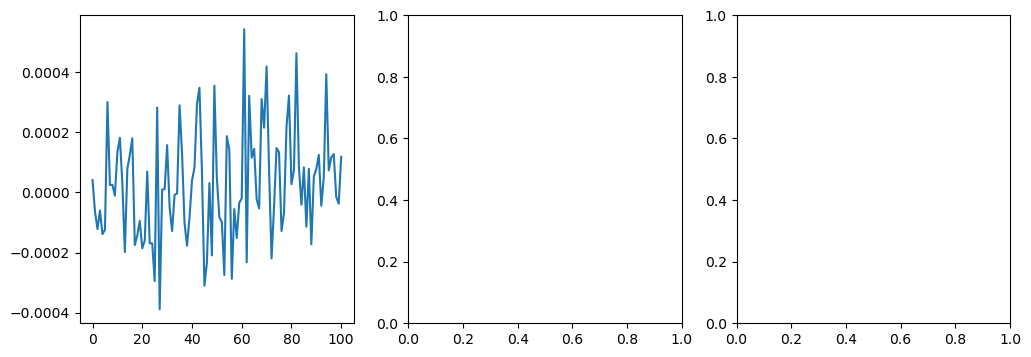

In [747]:
# plot the estimated and true state over time
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].plot(ukf_history[:, 0], label='Kalman Estimate')
# plot the error bars as colored regions
# y errors are the diagonal of the square root of the covariance matrix
yerr = np.sqrt(covar_history[:, 0, 0])
ax[0].fill_between(np.arange(num_steps), ukf_history[:, 0] - yerr, ukf_history[:, 0] + yerr, alpha=0.3)
ax[0].plot(true_state_history[:, 0], label='True Trajectory', linestyle='dotted')
#ax[0].plot(ekf_history[:, 0], label='EKF')

ax[1].plot(ukf_history[:, 1], label='Kalman Estimate')
yerr = np.sqrt(covar_history[:, 1, 1])
ax[1].fill_between(np.arange(num_steps), ukf_history[:, 1] - yerr, ukf_history[:, 1] + yerr, alpha=0.3)
ax[1].plot(true_state_history[:, 1], label='True Trajectory', linestyle='dotted')

ax[2].plot(ukf_history[:, 2], label='Kalman Estimate')
yerr = np.sqrt(covar_history[:, 2, 2])
ax[2].fill_between(np.arange(num_steps), ukf_history[:, 2] - yerr, ukf_history[:, 2] + yerr, alpha=0.3)
ax[2].plot(true_state_history[:, 2], label='True Trajectory', linestyle='dotted')

# ax[1].plot(true_state_history[:, 1], label='True Trajectory', linewidth=5)
# ax[1].plot(ukf_history[:, 1], label='Kalman Estimate')

# ax[2].plot(true_state_history[:, 2], label='True Trajectory', linewidth=5)
# ax[2].plot(ukf_history[:, 2], label='Kalman Estimate')


font_size = 16
ax[0].set_xlabel('k (time index)', fontsize=font_size)
ax[0].set_title('Error in $\\Delta (x[0])$', fontsize=font_size)
ax[0].set_ylabel('Error', fontsize=14)

#ax[1].plot(ekf_history[:, 1], label='EKF')
ax[1].set_title('Error in $\\Omega$ (x[1])', fontsize=font_size)

ax[2].set_title('Error in $\\phi$ (x[2])', fontsize=font_size)
# make the font larger for the labels

# set the axes to the same range 
yrange = [-0.2, 0.3]
for a in ax:
    a.set_ylim(yrange)



ax[2].legend(fontsize=font_size)
# set tight layout
plt.tight_layout()

